# Sentiment analysis of the spread of hate in tweets using RNN [Reproducible Research] 

## 1. Understanding the Problem Statement

Twitter is one of the biggest and most popular social networks with around 300 million users, 40% of which are active on the platform multiple times per day. Hence, it’s understandable the need to monitor the sentiment of the users, especially if it can help stop the spread of hateful and damaging massages.

The goal of our project is to reproduce the original project and to replicate the results using the dataset described below, with the aim of building a robust model for predicting hate tweets. The model is based on Recurrent Neural Networks (RNNs), with the implementation and evaluation of different layers such as LSTM, GRU. Furthermore, we used pretrained word vectors from GloVe model trained with tweets, which is loaded in our model in an Embedding layer.

## 2. About the dataset

The data used was found on Kaggle: 

https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset

The dataset used to build and evaluate the model contains 56744 rows and three columns: 
    
    id - ID assigned to each tweet
    toxicity - 1 if the tweeter is considered hateful and 0 non-hateful
    tweet - string containing tweet’s text.
    
Additionally, in our repository it is possible to find a diferent test dataset with 17197 unlabeled tweets which we will try to label in the end using our final and improved model (this last dataset comes from the original project).


## 3. Import Libraries

In [1]:
# Import modules

import numpy
import numpy as np
from numpy.random import seed

import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import inspect
import tensorflow
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

## 4. Read and Inspect the Data

In [2]:
data_columns = ["ids","label","tweet"]
tweets= pd.read_csv('training.csv', names=data_columns)[1:]
tweets.head()

,ids,label,tweet
1,0.0,0,@user when a father is dysfunctional and is s...
2,1.0,0,@user @user thanks for #lyft credit i can't us...
3,2.0,0,bihday your majesty
4,3.0,0,#model i love u take with u all the time in ...
5,4.0,0,factsguide: society now #motivation


In [3]:
#tweets=tweets.sample(frac = 0.3)

In [4]:
tweets["label"].replace({"0": 0, "1": 1}, inplace=True)

In [5]:
np.unique(tweets.label)

array([0, 1])

In [6]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (tweets.label == 1).sum(),
    (tweets.label == 0).sum()
))

Hatred labeled: 24153
Non-hatred labeled: 32592


## 5. Text Cleaning and Preprocessing

In [7]:
# remove URL's and @users
tweets['clean_tweet'] = tweets['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: re.sub(r'&#\S+', '', x))
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: re.sub('@[a-zA-Z0-9_]+', '', x))

In [8]:
#Removing hashtags and creating hashtags column
hashtags = tweets['clean_tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
tweets.loc[:, 'hashtags'] = hashtags['hashtag']
tweets['hashtags'].fillna('', inplace=True)


In [9]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
tweets['clean_tweet'] = tweets['clean_tweet'].str.lower()

# remove numbers
tweets['clean_tweet'] = tweets['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x:' '.join(x.split()))


In [10]:
#Lemmatizing tweets

#!pip3 install -U spacy
#!python3 -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [11]:
tweets['clean_tweet'] = lemmatization(tweets['clean_tweet'])

In [12]:
#Removing whatever non-character rest that could remain in the tweets

tweets['clean_tweet2'] = tweets.clean_tweet.str.replace('[^a-zA-Z]', ' ')
#tweets['lwords'] = tweets['clean_tweet2'].apply(lambda x: x.split())

In [80]:
pd.set_option("display.max_colwidth", -1)

<ipython-input-80-a09e5efec013>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [81]:
tweets.sample(50)

,ids,label,tweet,clean_tweet,hashtags,clean_tweet2
49390,49389.0,1,"RT @StevStiffler: If her bio says ""Only God can judge me"" she's a hoe.",rt if her bio say only god can judge I she be a hoe .,,rt if her bio say only god can judge I she be a hoe
31667,31666.0,0,@user and the industry is completely able to develope thousands of #recyclable materials. the #change is #always in our #hands,and the industry be completely able to develope thousand of recyclable material . the change be always in our hand,recyclable change always hands,and the industry be completely able to develope thousand of recyclable material the change be always in our hand
27417,27416.0,0,â #new zealand current account - gdp ratio meets forecasts (-3%) in 1q #blog #silver #gold #forex,â new zealand current account gdp ratio meet forecast in q blog silver gold forex,new blog silver gold forex,new zealand current account gdp ratio meet forecast in q blog silver gold forex
21650,21649.0,1,@user #allahsoil marx's revolution occurredâjust not how he expected it to. â¦ â¦ #teambtsâ¦,allahsoil marx 's revolution occurredâjust not how he expect it to . â ¦ â ¦ teambtsâ ¦,allahsoil teambts,allahsoil marx s revolution occurred just not how he expect it to teambts
38098,38097.0,1,@iStandy is he chunky?,be he chunky,,be he chunky
23398,23397.0,0,"""poem "" by @user on @user",poem by on,,poem by on
53367,53366.0,1,That long hair doesn't cover up your redneck,that long hair do not cover up your redneck,,that long hair do not cover up your redneck
13841,13840.0,0,@user bihday haryana clpleader,bihday haryana clpleader,,bihday haryana clpleader
15961,15960.0,0,played it... loved it. #horizonzerodawn #e3 #e32016,play it ... love it . horizonzerodawn e e,horizonzerodawn e3 e32016,play it love it horizonzerodawn e e
41572,41571.0,1,Ha.. Who can get the pussy quicker these days,ha .. who can get the pussy quick these day,,ha who can get the pussy quick these day


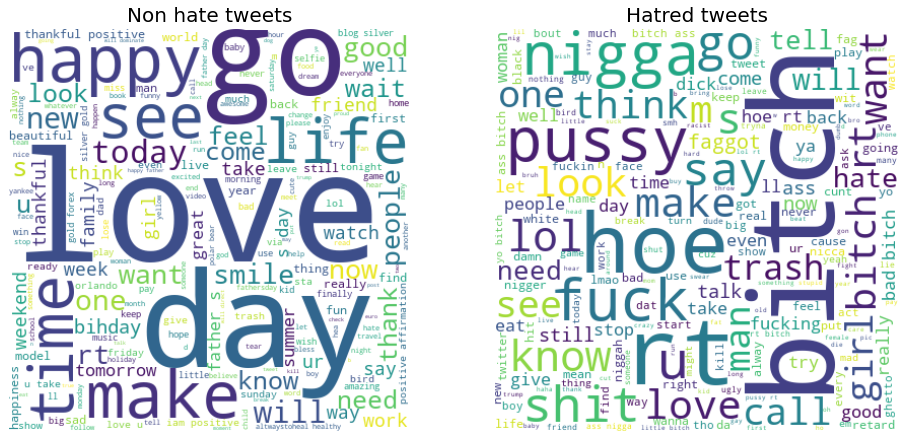

In [15]:
#Most used words

stopwords = STOPWORDS.add('amp')

nonhate_words = ' '.join(tweets[tweets.label == 0].clean_tweet2.values)
hatred_words = ' '.join(tweets[tweets.label == 1].clean_tweet2.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(nonhate_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Non hate tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

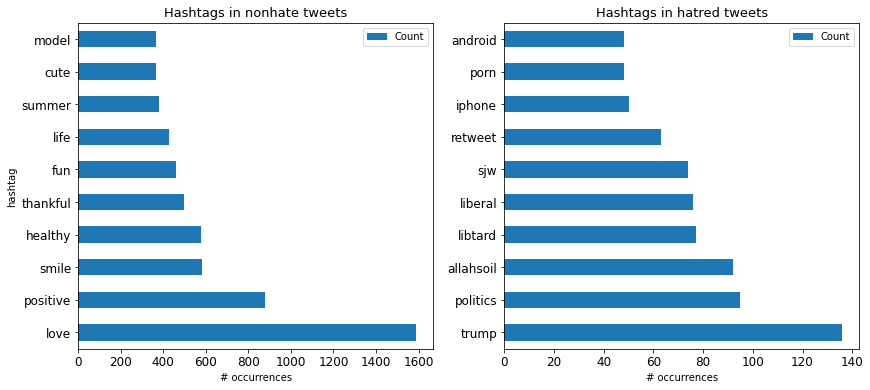

In [16]:
#Most used hashtags

nonhate_hashtags = FreqDist(list(' '.join(tweets[tweets.label==0].hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(tweets[tweets.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(nonhate_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in nonhate tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

In [17]:
#Splitting the data in 80% train and 20% test

X_train, X_test, Y_train, Y_test = train_test_split(list(tweets.clean_tweet2), list(tweets.label),test_size=0.2, random_state=42)

## 6. Pretrained word vectors

### Global Vectors for Word Representation (GloVe)
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm developed by researchers at Stanford University aiming to generate word embeddings (vector representations for words). Its training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space which have the potential for encoding some form of meaning. It's essentially a log-bilinear model with a weighted least-squares objective.

#### Pre-trained GloVe word vectors used:

Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [18]:
#Crating glove dictionary from downloaded pre-trained GloVe word vectors

def get_glove_vectors(filename="glove.twitter.27B.200d.txt"):
    # Get all word vectors from pre-trained model
    glove_vector_dict = {}
    with open(filename) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
    
    return glove_vector_dict

In [19]:
glove_dict=get_glove_vectors()

In [20]:
#Encoding vocabulary from training tweets

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [21]:
print(tokenizer.word_index)

{'be': 1, 'i': 2, 'the': 3, 'a': 4, 'to': 5, 'you': 6, 'bitch': 7, 'not': 8, 'and': 9, 'in': 10, 'rt': 11, 'my': 12, 'of': 13, 'for': 14, 'do': 15, 'that': 16, 'it': 17, 'on': 18, 'get': 19, 'this': 20, 'have': 21, 'with': 22, 'hoe': 23, 'all': 24, 'like': 25, 'love': 26, 'so': 27, 'day': 28, 'they': 29, 'your': 30, 'can': 31, 'we': 32, 'just': 33, 'at': 34, 'go': 35, 's': 36, 'when': 37, 'but': 38, 'up': 39, 'amp': 40, 'u': 41, 'pussy': 42, 'he': 43, 'she': 44, 'what': 45, 'if': 46, 'no': 47, 'make': 48, 'good': 49, 'will': 50, 'out': 51, 'happy': 52, 'fuck': 53, 'time': 54, 'about': 55, 'see': 56, 'these': 57, 'from': 58, 'as': 59, 'ass': 60, 'how': 61, 'say': 62, 'now': 63, 'one': 64, 'life': 65, 'want': 66, 'know': 67, 'look': 68, 'shit': 69, 'who': 70, 'today': 71, 'some': 72, 'take': 73, 'lol': 74, 'girl': 75, 'new': 76, 'people': 77, 'think': 78, 'nigga': 79, 'need': 80, 'come': 81, 'or': 82, 'by': 83, 'trash': 84, 'more': 85, 'well': 86, 'why': 87, 'his': 88, 'man': 89, 'an': 9

In [22]:
#Number of words in our vocabulary

len(tokenizer.word_index)

38709

In [23]:
# Filter GLoVE vectors to our specific vocabulary

def filter_glove(vocabulary_dict, glove_dict, wordvec_dim):
    # Create a matrix to store the vectors
    embedding_matrix = np.zeros((len(vocabulary_dict) + 1, wordvec_dim))
    for word,i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [24]:
glove_matrix = filter_glove(vocabulary_dict=tokenizer.word_index,glove_dict=glove_dict,wordvec_dim=200)
print(glove_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.72794002  0.41955999 -0.28589001 ... -0.1469     -0.035087
  -0.022335  ]
 [ 0.056404    0.49535999  0.18438999 ...  0.63598001 -0.18880001
  -0.035558  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [25]:
len(glove_matrix)

38710

## 7. Prepare the (X, Y) variables to fit the model

In [26]:
# Change texts into sequence of indexes
train_numeric = tokenizer.texts_to_sequences(X_train)
test_numeric = tokenizer.texts_to_sequences(X_test)

In [27]:
for i in range(3):
    print('\n',train_numeric[i],"\n\n",len(train_numeric[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [13, 172, 1, 660, 2223, 121, 13, 863, 114, 57, 23, 1, 145] 

 13 

 ['of', 'woman', 'be', 'slut', 'freshman', 'year', 'of', 'college', 'let', 'these', 'hoe', 'be', 'great'] 

 13 

********************** 0

 [14598, 14599, 304, 165, 92, 5, 14600, 3, 4161, 14601, 299, 102, 108, 93, 1, 220, 4571, 1076, 10, 3, 1495, 5, 2728, 43] 

 24 

 ['kip', 'tokuda', 'yellow', 'guy', 'work', 'to', 'niggerize', 'the', 'seattle', 'pd', 'die', 'too', 'bad', 'there', 'be', 'another', 'pos', 'hide', 'in', 'the', 'wing', 'to', 'replace', 'he'] 

 24 

********************** 1

 [421, 40, 1, 14602, 14603] 

 5 

 ['laugh', 'amp', 'be', 'positip', 'plusfactorph'] 

 5 

********************** 2


In [28]:
# Largest tweet

largest=0
for i in range(len(train_numeric)):
    largest=max(largest,len(train_numeric[i]))
for i in range(len(test_numeric)):
    largest=max(largest,len(test_numeric[i]))
    
print(largest)

37


In [29]:
# Pad the sequences
train_pad = pad_sequences(train_numeric, largest)
test_pad = pad_sequences(test_numeric, largest)
Y_train = numpy.array(Y_train)
Y_test = numpy.array(Y_test)

In [30]:
for i in range(3):
    print('\n',train_pad[i],"\n\n",len(train_pad[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   13  172    1  660
 2223  121   13  863  114   57   23    1  145] 

 37 

 ['of', 'woman', 'be', 'slut', 'freshman', 'year', 'of', 'college', 'let', 'these', 'hoe', 'be', 'great'] 

 13 

********************** 0

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0 14598 14599   304   165    92     5 14600     3  4161 14601   299
   102   108    93     1   220  4571  1076    10     3  1495     5  2728
    43] 

 37 

 ['kip', 'tokuda', 'yellow', 'guy', 'work', 'to', 'niggerize', 'the', 'seattle', 'pd', 'die', 'too', 'bad', 'there', 'be', 'another', 'pos', 'hide', 'in', 'the', 'wing', 'to', 'replace', 'he'] 

 24 

********************** 1

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

## 8. Creating the model using keras

In the model different layers are applied such as Dropout, LSTM and Gru to account for the issues that might arise when implementing a RNN model. 

- Both LSTM and GRU layers are used to account for "Exploding Gradient" and "Vanishing Gradient" issues. 

- Dropout is used "to prevent over-fitting" by ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random.

- Also, pre-trained weights are used in this model by passing Glove to the Embedding layer. This improves much more the performance since it gives information to the model about the probability for most of the words to appear in the tweets.

### Basic RNN model with LSTM, GRU and Dropout layers

In [41]:
# Instantiate the model class
model_basic = Sequential()

# Add the layers
model_basic.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    input_length=largest, name="Embedding"))
model_basic.add(Dense(200,activation='relu', name="Dense1"))
model_basic.add(Dropout(rate=0.25))
model_basic.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM"))
model_basic.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU"))
model_basic.add(Dense(64, name="Dense2"))
model_basic.add(Dropout(rate=0.25))
model_basic.add(Dense(32, name="Dense3"))
model_basic.add(Dense(1, activation='sigmoid', name="Output"))

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
history = model_basic.fit(train_pad,Y_train, epochs=10, validation_data=(test_pad,Y_test), batch_size=32)

Epoch 1/10
1419/1419 [==============================] - 52s 35ms/step - loss: 0.2821 - accuracy: 0.8834 - val_loss: 0.1957 - val_accuracy: 0.9258
Epoch 2/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1884 - accuracy: 0.9305 - val_loss: 0.1702 - val_accuracy: 0.9332
Epoch 3/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1660 - accuracy: 0.9374 - val_loss: 0.1665 - val_accuracy: 0.9360
Epoch 4/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1553 - accuracy: 0.9426 - val_loss: 0.1640 - val_accuracy: 0.9393
Epoch 5/10
1419/1419 [==============================] - 48s 34ms/step - loss: 0.1447 - accuracy: 0.9459 - val_loss: 0.1585 - val_accuracy: 0.9411
Epoch 6/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1353 - accuracy: 0.9493 - val_loss: 0.1595 - val_accuracy: 0.9403
Epoch 7/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1268 - accuracy: 0.9528 - val_loss: 0.1580 -

In [42]:
model_basic.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 37, 200)           7742000   
                                                                 
 Dense1 (Dense)              (None, 37, 200)           40200     
                                                                 
 dropout_54 (Dropout)        (None, 37, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 37, 64)            67840     
                                                                 
 GRU (GRU)                   (None, 64)                24960     
                                                                 
 Dense2 (Dense)              (None, 64)                4160      
                                                                 
 dropout_55 (Dropout)        (None, 64)              

In [43]:
print('Loss:',round(np.mean(history.history['val_loss']),4),'Accuracy:',round(100*np.mean(history.history['val_accuracy']),2),'%')

Loss: 0.1668 Accuracy: 93.81 %


### Adding Glove pretrained word vectors to the model

In [38]:
# Instantiate the model class
model_GloVe = Sequential()

# Add the layers
model_GloVe.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model_GloVe.add(Dense(200,activation='relu', name="Dense1"))
model_GloVe.add(Dropout(rate=0.25))
model_GloVe.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM"))
model_GloVe.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU"))
model_GloVe.add(Dense(64, name="Dense2"))
model_GloVe.add(Dropout(rate=0.25))
model_GloVe.add(Dense(32, name="Dense3"))
model_GloVe.add(Dense(1, activation='sigmoid', name="Output"))

model_GloVe.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
history = model_GloVe.fit(train_pad,Y_train, epochs=10, validation_data=(test_pad,Y_test), batch_size=32)

Epoch 1/10
1419/1419 [==============================] - 53s 35ms/step - loss: 0.2031 - accuracy: 0.9217 - val_loss: 0.1686 - val_accuracy: 0.9356
Epoch 2/10
1419/1419 [==============================] - 46s 32ms/step - loss: 0.1583 - accuracy: 0.9385 - val_loss: 0.1613 - val_accuracy: 0.9372
Epoch 3/10
1419/1419 [==============================] - 45s 32ms/step - loss: 0.1451 - accuracy: 0.9437 - val_loss: 0.1532 - val_accuracy: 0.9401
Epoch 4/10
1419/1419 [==============================] - 46s 32ms/step - loss: 0.1350 - accuracy: 0.9478 - val_loss: 0.1538 - val_accuracy: 0.9421
Epoch 5/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1263 - accuracy: 0.9516 - val_loss: 0.1487 - val_accuracy: 0.9421
Epoch 6/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1177 - accuracy: 0.9538 - val_loss: 0.1465 - val_accuracy: 0.9462
Epoch 7/10
1419/1419 [==============================] - 46s 33ms/step - loss: 0.1083 - accuracy: 0.9582 - val_loss: 0.1440 -

In [39]:
print('Loss:',round(np.mean(history.history['val_loss']),4),'Accuracy:',round(100*np.mean(history.history['val_accuracy']),2),'%')

Loss: 0.1536 Accuracy: 94.24 %


## 9. Evaluating the model with different parameters and CNN layer

List of paramaters which are optimized:

- Batch size of the model - it pertains to the amount of training samples to consider at a time for updating the network weights
- The dropout rate - fraction of the input units to drop, used to add noise to the model
- Trainable argument of the Embedding layer - false for keeping the weights fixed and True if the weights will be updated during the training
- Adding Conv1D layer from Convolutional Neural Network - creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs

### Parameters tuning 

In [44]:
# epochs: determine how many weight updates will be done on the model -> We choose 20
# batch_size: size of the data on each step -> Also increases the speed of the training, depends on the computer capacity
# drop: rate of the dropout layer, used to add noise to the model 

model_list = []
for drop in [0, 0.1, 0.2, 0.3, 0.4]:
    for batch in [16, 32, 64, 80]:
        seed(321)
        tensorflow.random.set_seed(123)
    
        model = Sequential()

        # Add the layers
        model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                            output_dim=200,
                            trainable=False,
                            embeddings_initializer=Constant(glove_matrix),
                            input_length=largest, name="Embedding"))
        model.add(Dense(200,activation='relu', name="Dense1"))
        model.add(Dropout(drop))
        model.add(LSTM(64, return_sequences=True, dropout=drop, name="LSTM"))
        model.add(GRU(64, return_sequences=False, dropout=drop, name="GRU"))
        model.add(Dense(64, name="Dense2"))
        model.add(Dropout(drop))
        model.add(Dense(32, name="Dense3"))
        model.add(Dense(1, activation='sigmoid', name="Output"))

        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        print(drop,batch)
        
        history = model.fit(train_pad,Y_train, epochs=10, validation_data=(test_pad,Y_test), batch_size=batch)
        model_list.append([drop, batch, np.mean(history.history['val_loss']),np.mean(history.history['val_accuracy'])])

0 16
Epoch 1/10
2838/2838 [==============================] - 74s 25ms/step - loss: 0.1855 - accuracy: 0.9288 - val_loss: 0.1587 - val_accuracy: 0.9385
Epoch 2/10
2838/2838 [==============================] - 70s 25ms/step - loss: 0.1473 - accuracy: 0.9428 - val_loss: 0.1583 - val_accuracy: 0.9385
Epoch 3/10
2838/2838 [==============================] - 70s 25ms/step - loss: 0.1272 - accuracy: 0.9497 - val_loss: 0.1497 - val_accuracy: 0.9411
Epoch 4/10
2838/2838 [==============================] - 71s 25ms/step - loss: 0.1090 - accuracy: 0.9584 - val_loss: 0.1547 - val_accuracy: 0.9452
Epoch 5/10
2838/2838 [==============================] - 72s 25ms/step - loss: 0.0895 - accuracy: 0.9653 - val_loss: 0.1561 - val_accuracy: 0.9433
Epoch 6/10
2838/2838 [==============================] - 71s 25ms/step - loss: 0.0706 - accuracy: 0.9729 - val_loss: 0.1656 - val_accuracy: 0.9415
Epoch 7/10
2838/2838 [==============================] - 72s 25ms/step - loss: 0.0537 - accuracy: 0.9799 - val_loss: 0.1

568/568 [==============================] - 32s 57ms/step - loss: 0.1481 - accuracy: 0.9429 - val_loss: 0.1663 - val_accuracy: 0.9359
Epoch 4/10
568/568 [==============================] - 31s 55ms/step - loss: 0.1384 - accuracy: 0.9467 - val_loss: 0.1563 - val_accuracy: 0.9402
Epoch 5/10
568/568 [==============================] - 33s 59ms/step - loss: 0.1299 - accuracy: 0.9491 - val_loss: 0.1482 - val_accuracy: 0.9429
Epoch 6/10
568/568 [==============================] - 32s 56ms/step - loss: 0.1239 - accuracy: 0.9522 - val_loss: 0.1469 - val_accuracy: 0.9436
Epoch 7/10
568/568 [==============================] - 33s 58ms/step - loss: 0.1154 - accuracy: 0.9544 - val_loss: 0.1486 - val_accuracy: 0.9434
Epoch 8/10
568/568 [==============================] - 32s 56ms/step - loss: 0.1085 - accuracy: 0.9584 - val_loss: 0.1541 - val_accuracy: 0.9449
Epoch 9/10
568/568 [==============================] - 33s 58ms/step - loss: 0.1029 - accuracy: 0.9602 - val_loss: 0.1528 - val_accuracy: 0.9447
Epo

In [45]:
df_models = pd.DataFrame(model_list, columns = ['dropout', 'batch', 'loss', 'accuracy'])

In [46]:
df_models.sort_values('loss').head()

,dropout,batch,loss,accuracy
12,0.3,16,0.153357,0.941264
13,0.3,32,0.153782,0.942083
9,0.2,32,0.154403,0.942955
11,0.2,80,0.155375,0.941219
14,0.3,64,0.155473,0.940876


In [48]:
df_models.sort_values('accuracy',ascending=False).head()

,dropout,batch,loss,accuracy
9,0.2,32,0.154403,0.942955
8,0.2,16,0.157396,0.942594
13,0.3,32,0.153782,0.942083
5,0.1,32,0.164965,0.941775
4,0.1,16,0.163177,0.941510


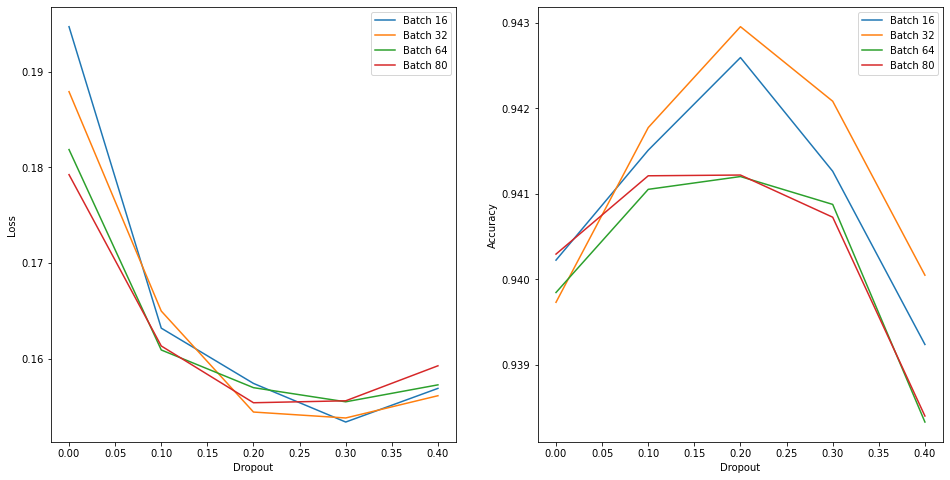

In [52]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(df_models[df_models['batch']==16]['dropout'],df_models[df_models['batch']==16]['loss'])
plt.plot(df_models[df_models['batch']==32]['dropout'],df_models[df_models['batch']==32]['loss'])
plt.plot(df_models[df_models['batch']==64]['dropout'],df_models[df_models['batch']==64]['loss'])
plt.plot(df_models[df_models['batch']==80]['dropout'],df_models[df_models['batch']==80]['loss'])
plt.xlabel("Dropout")
plt.ylabel('Loss')
plt.legend(['Batch 16', 'Batch 32', 'Batch 64', 'Batch 80'])

plt.subplot(1, 2, 2)
plt.plot(df_models[df_models['batch']==16]['dropout'],df_models[df_models['batch']==16]['accuracy'])
plt.plot(df_models[df_models['batch']==32]['dropout'],df_models[df_models['batch']==32]['accuracy'])
plt.plot(df_models[df_models['batch']==64]['dropout'],df_models[df_models['batch']==64]['accuracy'])
plt.plot(df_models[df_models['batch']==80]['dropout'],df_models[df_models['batch']==80]['accuracy'])
plt.xlabel("Dropout")
plt.ylabel('Accuracy')
plt.legend(['Batch 16', 'Batch 32', 'Batch 64', 'Batch 80'])

The highest accuracy is achieved with drop=0.2 and batch_size=32, so this will be our chosen parameters for the model.

### Chosen parameters model

In [54]:
# Instantiate the model class
model = Sequential()

# Add the layers
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model.add(Dense(200,activation='relu', name="Dense1"))
model.add(Dropout(rate=0.2))
model.add(LSTM(64, return_sequences=True, dropout=0.2, name="LSTM"))
model.add(GRU(64, return_sequences=False, dropout=0.2, name="GRU"))
model.add(Dense(64, name="Dense2"))
model.add(Dropout(rate=0.2))
model.add(Dense(32, name="Dense3"))
model.add(Dense(1, activation='sigmoid', name="Output"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(train_pad,Y_train,
                       epochs=10,
                       validation_data=(test_pad,Y_test),
                       batch_size=32)

Epoch 1/10
1419/1419 [==============================] - 51s 34ms/step - loss: 0.2032 - accuracy: 0.9213 - val_loss: 0.1686 - val_accuracy: 0.9360
Epoch 2/10
1419/1419 [==============================] - 47s 33ms/step - loss: 0.1582 - accuracy: 0.9391 - val_loss: 0.1620 - val_accuracy: 0.9352
Epoch 3/10
1419/1419 [==============================] - 52s 36ms/step - loss: 0.1460 - accuracy: 0.9436 - val_loss: 0.1569 - val_accuracy: 0.9373
Epoch 4/10
1419/1419 [==============================] - 53s 37ms/step - loss: 0.1356 - accuracy: 0.9467 - val_loss: 0.1506 - val_accuracy: 0.9439
Epoch 5/10
1419/1419 [==============================] - 46s 33ms/step - loss: 0.1266 - accuracy: 0.9502 - val_loss: 0.1482 - val_accuracy: 0.9434
Epoch 6/10
1419/1419 [==============================] - 46s 32ms/step - loss: 0.1175 - accuracy: 0.9548 - val_loss: 0.1499 - val_accuracy: 0.9420
Epoch 7/10
1419/1419 [==============================] - 48s 34ms/step - loss: 0.1096 - accuracy: 0.9572 - val_loss: 0.1478 -

In [56]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'test_'+metric])

(0.0, 0.2088667292147875)

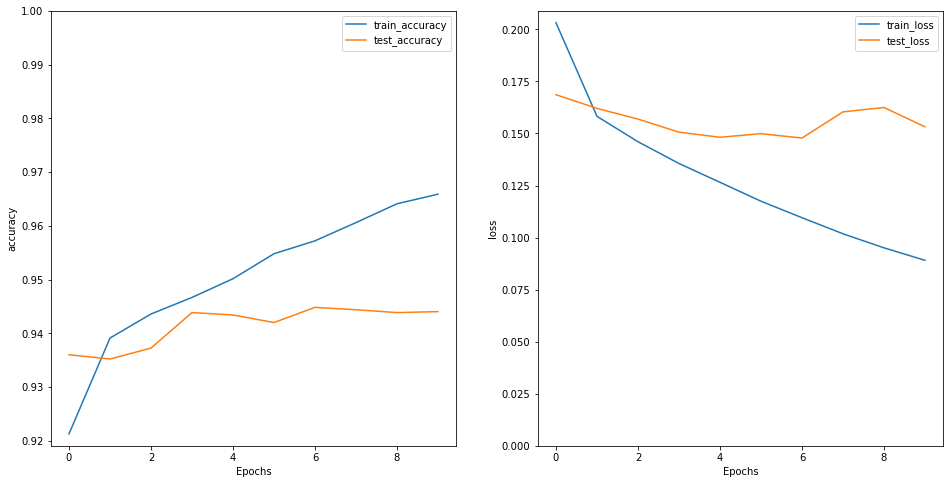

In [57]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [58]:
#Evaluate the model:
score_train, acc_train = model.evaluate(train_pad, Y_train)
score_test, acc_test = model.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train,4),'Acc:',round(acc_train*100,2),'% ')
print('Test:\n Loss:',round(score_test,4),'Acc:',round(acc_test*100,2),'% ')

355/355 [==============================] - 3s 10ms/step - loss: 0.1532 - accuracy: 0.9440
Train:
 Loss: 0.0583 Acc: 98.03 % 
Test:
 Loss: 0.1532 Acc: 94.4 % 


### Trainable Embedding layer

In [59]:
# Instantiate the model class
model_trainable = Sequential()

# Add the layers
model_trainable.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=True,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model_trainable.add(Dense(200,activation='relu', name="Dense1"))
model_trainable.add(Dropout(rate=0.2))
model_trainable.add(LSTM(64, return_sequences=True, dropout=0.2, name="LSTM"))
model_trainable.add(GRU(64, return_sequences=False, dropout=0.2, name="GRU"))
model_trainable.add(Dense(64, name="Dense2"))
model_trainable.add(Dropout(rate=0.2))
model_trainable.add(Dense(32, name="Dense3"))
model_trainable.add(Dense(1, activation='sigmoid', name="Output"))

model_trainable.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_trainable.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 37, 200)           7742000   
                                                                 
 Dense1 (Dense)              (None, 37, 200)           40200     
                                                                 
 dropout_98 (Dropout)        (None, 37, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 37, 64)            67840     
                                                                 
 GRU (GRU)                   (None, 64)                24960     
                                                                 
 Dense2 (Dense)              (None, 64)                4160      
                                                                 
 dropout_99 (Dropout)        (None, 64)              

In [60]:
history = model_trainable.fit(train_pad,Y_train,
                              epochs=10,
                              validation_data=(test_pad,Y_test),
                              batch_size=32)

Epoch 1/10
1419/1419 [==============================] - 137s 93ms/step - loss: 0.1851 - accuracy: 0.9284 - val_loss: 0.1436 - val_accuracy: 0.9454
Epoch 2/10
1419/1419 [==============================] - 143s 100ms/step - loss: 0.1016 - accuracy: 0.9619 - val_loss: 0.1427 - val_accuracy: 0.9475
Epoch 3/10
1419/1419 [==============================] - 139s 98ms/step - loss: 0.0641 - accuracy: 0.9768 - val_loss: 0.1747 - val_accuracy: 0.9386
Epoch 4/10
1419/1419 [==============================] - 142s 100ms/step - loss: 0.0473 - accuracy: 0.9832 - val_loss: 0.1992 - val_accuracy: 0.9413
Epoch 5/10
1419/1419 [==============================] - 135s 95ms/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0.2409 - val_accuracy: 0.9345
Epoch 6/10
1419/1419 [==============================] - 143s 101ms/step - loss: 0.0272 - accuracy: 0.9907 - val_loss: 0.2310 - val_accuracy: 0.9366
Epoch 7/10
1419/1419 [==============================] - 150s 105ms/step - loss: 0.0233 - accuracy: 0.9917 - val_los

(0.0, 0.4359291675500572)

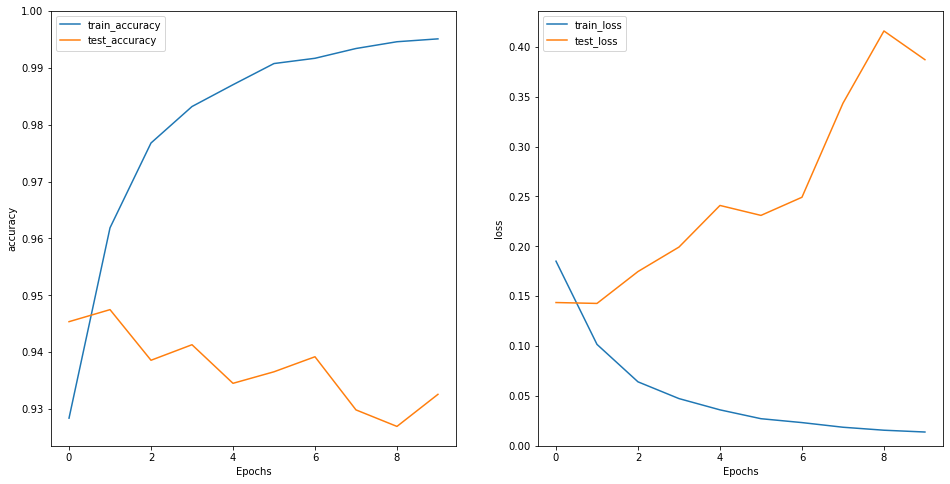

In [61]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [62]:
#Evaluate the model:
score_train_trainable, acc_train_trainable = model_trainable.evaluate(train_pad, Y_train)
score_test_trainable, acc_test_trainable = model_trainable.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train_trainable,4),'Acc:',round(acc_train_trainable*100,2),'% ')
print('Test:\n Loss:',round(score_test_trainable,4),'Acc:',round(acc_test_trainable*100,2),'% ')

355/355 [==============================] - 3s 9ms/step - loss: 0.3871 - accuracy: 0.9326
Train:
 Loss: 0.007 Acc: 99.79 % 
Test:
 Loss: 0.3871 Acc: 93.26 % 


It improved the performance for the training dataset, but it got worse for the test one. This seems logic since training more parameters we got to make the model more specific,i.e., we trained it to make better predictions on tweets more similar to the ones we used for training it. It makes the model less general, and worse predicting new and more different tweets. It is something similar to what happens when reducing the drop_out rate.

Therefore, we stablish the trainable argument = False.

### Convolution layer

The mix of convolution and max pooling layers with RNN cells has been used recently and achieved state of the art results in NLP problems. In short:

- The Conv1D has filters that determines the output dimension, kernel size which is the window size for convolution and padding which determines if the input should be padded (add zeros around the matrix) or not. 

- The MaxPooling1D contains the parameter pool size that determines the window to look for the max value. 

In [63]:
# Instantiate the model class
modelcnn = Sequential()

# Add the layers
modelcnn.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
modelcnn.add(Conv1D(filters=32, kernel_size=3, padding='same'))
modelcnn.add(MaxPooling1D(pool_size=2))
modelcnn.add(Dense(200,activation='relu', name="Dense1"))
modelcnn.add(Dropout(rate=0.2))
modelcnn.add(LSTM(64, return_sequences=True, dropout=0.2, name="LSTM"))
modelcnn.add(GRU(64, return_sequences=False, dropout=0.2, name="GRU"))
modelcnn.add(Dense(64, name="Dense2"))
modelcnn.add(Dropout(rate=0.2))
modelcnn.add(Dense(32, name="Dense3"))
modelcnn.add(Dense(1, activation='sigmoid', name="Output"))

modelcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelcnn.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 37, 200)           7742000   
                                                                 
 conv1d (Conv1D)             (None, 37, 32)            19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 Dense1 (Dense)              (None, 18, 200)           6600      
                                                                 
 dropout_100 (Dropout)       (None, 18, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 18, 64)            67840     
                                                     

In [64]:
history = modelcnn.fit(train_pad,Y_train,
                       epochs=10,
                       validation_data=(test_pad,Y_test),
                       batch_size=32)

Epoch 1/10
1419/1419 [==============================] - 35s 22ms/step - loss: 0.2153 - accuracy: 0.9154 - val_loss: 0.1872 - val_accuracy: 0.9295
Epoch 2/10
1419/1419 [==============================] - 33s 23ms/step - loss: 0.1654 - accuracy: 0.9363 - val_loss: 0.1667 - val_accuracy: 0.9329
Epoch 3/10
1419/1419 [==============================] - 37s 26ms/step - loss: 0.1491 - accuracy: 0.9430 - val_loss: 0.1709 - val_accuracy: 0.9329
Epoch 4/10
1419/1419 [==============================] - 34s 24ms/step - loss: 0.1345 - accuracy: 0.9490 - val_loss: 0.1703 - val_accuracy: 0.9335
Epoch 5/10
1419/1419 [==============================] - 32s 23ms/step - loss: 0.1212 - accuracy: 0.9528 - val_loss: 0.1760 - val_accuracy: 0.9353
Epoch 6/10
1419/1419 [==============================] - 33s 23ms/step - loss: 0.1089 - accuracy: 0.9578 - val_loss: 0.1723 - val_accuracy: 0.9320
Epoch 7/10
1419/1419 [==============================] - 33s 23ms/step - loss: 0.0989 - accuracy: 0.9630 - val_loss: 0.1924 -

(0.0, 0.2222105573862791)

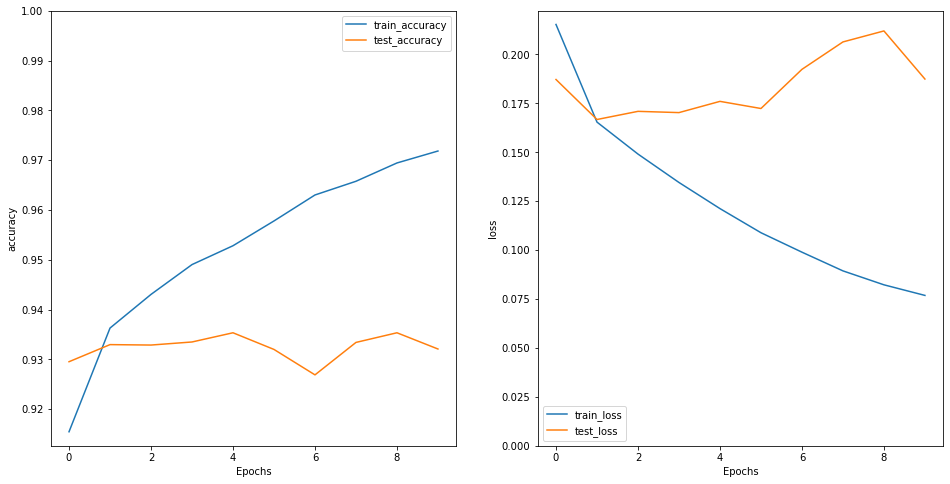

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [66]:
#Evaluate the model:
score_train_cnn, acc_train_cnn = modelcnn.evaluate(train_pad, Y_train)
score_test_cnn, acc_test_cnn = modelcnn.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train_cnn,4),'% ','Acc:',round(acc_train_cnn*100,2),'% ')
print('Test:\n Loss:',round(score_test_cnn,4),'% ','Acc:',round(acc_test_cnn*100,2),'% ')

355/355 [==============================] - 3s 8ms/step - loss: 0.1874 - accuracy: 0.9321
Train:
 Loss: 0.053 %  Acc: 98.41 % 
Test:
 Loss: 0.1874 %  Acc: 93.21 % 


In a similar way like the trainable embedding layer, the convolution layers improved a litte the performance of the model for the training dataset, but it got worse for the test one. The test loss increases with the trainings and the accuracy seems to lightly decrease.

Therefore, we decide to reject the idea of adding CNN layers to the model.